In [26]:
# Two lines that remove tensorflow GPU logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil



In [27]:
# Loads csv files and appends pixels to X and labels to y
def preprocess_data():
    data = pd.read_csv('data/fer2013.csv')
    labels = pd.read_csv('data/fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y

In [28]:

def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y


def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Dividindo o dataset em Train e Test
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size)

    return x_train, y_train, x_val, y_val, x_test, y_test


def data_augmentation(x_train): # Data augmentation para balancear o dataset
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen


def show_augmented_images(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        # plt.xlabel(class_names[y_train[i]])
    plt.show()


def define_model(input_shape=(48, 48, 1), classes=7):
    num_features = 64

    model = Sequential()

    #i wanna build a model with yolo architecture
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2 * 2 * 2 * num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 * 2 * num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 * num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    # return model

    # # i wanna build a model with SSD architecture
    # # 1st block
    # model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    # model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Dropout(0.5))

    # # 2nd block
    # model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Dropout(0.5))
    
    # # 3rd block
    # model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Dropout(0.5))


    # # 1st stage 
    # model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))
    # model.add(Conv2D(num_features, kernel_size=(3, 3)))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))
    # model.add(Dropout(0.5)) #Dropout is a simple and powerful regularization technique for neural networks and deep learning models.

    # # 2nd stage
    # model.add(Conv2D(num_features, (3, 3), activation='relu'))
    # model.add(Conv2D(num_features, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # # 3rd stage
    # model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))
    # model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))

    # # 4th stage
    # model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    # model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # # 5th stage
    # model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))
    # model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    # model.add(BatchNormalization())
    # model.add(Activation(activation='relu'))

    # model.add(Flatten()) # achatando o modelo

    # # Fully connected neural networks
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))

    # model.add(Dense(classes, activation='softmax'))

    return model


def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()


def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('Saved-Models\\model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('Saved-Models\\model' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')


def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')


def run_model():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    X, y = preprocess_data()
    X, y = clean_data_and_normalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
    datagen = data_augmentation(x_train)

    epochs = 160
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch
    model = define_model(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val), verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

    plot_acc_loss(history)
    save_model_and_weights(model, test_acc)


X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_39 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 20, 20, 128)       73856     
                

/opt/homebrew/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/160
443/443 - 146s - loss: 0.4166 - accuracy: 0.2702 - val_loss: 0.4215 - val_accuracy: 0.3801 - 146s/epoch - 329ms/step
Epoch 2/160
443/443 - 160s - loss: 0.3739 - accuracy: 0.3325 - val_loss: 0.3929 - val_accuracy: 0.3801 - 160s/epoch - 361ms/step
Epoch 3/160
443/443 - 166s - loss: 0.3670 - accuracy: 0.3411 - val_loss: 0.3742 - val_accuracy: 0.3801 - 166s/epoch - 374ms/step
Epoch 4/160
443/443 - 170s - loss: 0.3618 - accuracy: 0.3535 - val_loss: 0.3496 - val_accuracy: 0.3807 - 170s/epoch - 384ms/step
Epoch 5/160
443/443 - 171s - loss: 0.3562 - accuracy: 0.3669 - val_loss: 0.3396 - val_accuracy: 0.4277 - 171s/epoch - 385ms/step
Epoch 6/160
443/443 - 171s - loss: 0.3470 - accuracy: 0.3965 - val_loss: 0.3307 - val_accuracy: 0.4382 - 171s/epoch - 387ms/step
Epoch 7/160
443/443 - 175s - loss: 0.3402 - accuracy: 0.4126 - val_loss: 0.3245 - val_accuracy: 0.4432 - 175s/epoch - 395ms/step
Epoch 8/160
443/443 - 195s - loss: 0.3336 - accuracy: 0.4361 - val_loss: 0.3137 - val_accuracy: 0

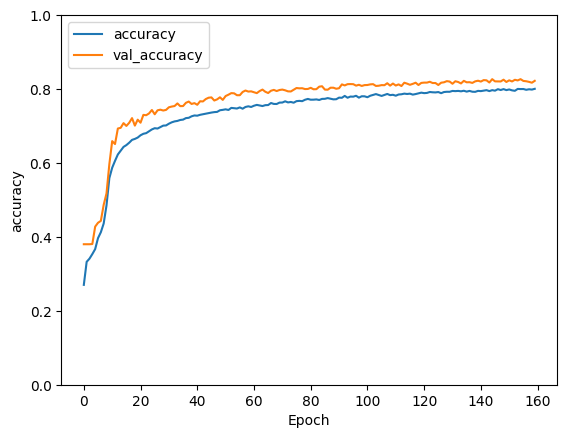

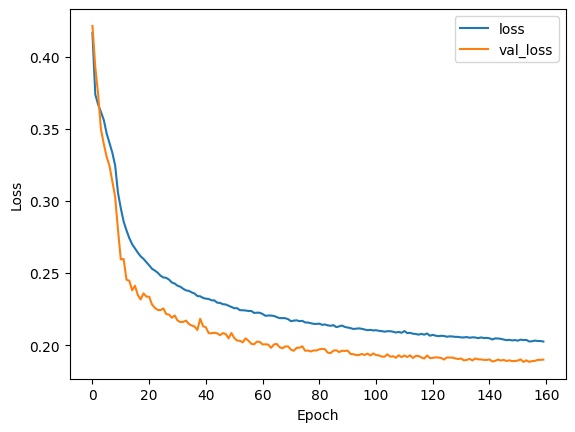

Model and weights are saved in separate files.


: 

In [29]:
run_model()